### Model Training

In [0]:
import pandas as pd

# load objects saved in prior notebook
X_train = pd.read_parquet('/dbfs/tmp/X_train.parquet')
X_val = pd.read_parquet('/dbfs/tmp/X_val.parquet')
y_train = pd.read_parquet('/dbfs/tmp/y_train.parquet')
y_val = pd.read_parquet('/dbfs/tmp/y_val.parquet')
best_params_df = pd.read_parquet('/dbfs/tmp/best_params.parquet')

# convert best_params dataframe to dictionary 
best_params = best_params_df.iloc[0].to_dict()

In [0]:
# ensure all parameters have the correct data types
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params

{'colsample_bytree': 0.7321852049385863,
 'learning_rate': 0.0723333004186679,
 'max_depth': 8,
 'n_estimators': 304,
 'subsample': 0.808070248943734}

In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
import mlflow
import mlflow.xgboost

# train model selected by AutoML with parameters discovered in tuning step
best_model = xgb.XGBRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

# predict on validation set
y_val_pred = best_model.predict(X_val)

# calculate validation metrics 
rmse = root_mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
mape = mean_absolute_percentage_error(y_val, y_val_pred)

print(f'Validation RMSE: {rmse}')
print(f'Validation R2: {r2}')
print(f'Validation MAPE: {mape}')

# log final model and metrics with MLflow
with mlflow.start_run(run_name='final_xgb_model'):
    mlflow.xgboost.log_model(best_model, 'model',
    registered_model_name='xgb_housing_model')
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)
    mlflow.log_metric('mape', mape)


/databricks/python/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:108889.22593
[1]	validation_0-rmse:104158.20682
[2]	validation_0-rmse:99334.80262
[3]	validation_0-rmse:94871.93634
[4]	validation_0-rmse:91050.50638
[5]	validation_0-rmse:87796.72487
[6]	validation_0-rmse:84398.29351
[7]	validation_0-rmse:81002.68198
[8]	validation_0-rmse:78656.54397
[9]	validation_0-rmse:75961.67811
[10]	validation_0-rmse:73593.37937
[11]	validation_0-rmse:71705.36188
[12]	validation_0-rmse:69643.38734
[13]	validation_0-rmse:67780.73696
[14]	validation_0-rmse:66044.66813
[15]	validation_0-rmse:64327.12879
[16]	validation_0-rmse:62929.88058
[17]	validation_0-rmse:61794.30605
[18]	validation_0-rmse:60656.13454
[19]	validation_0-rmse:59837.87751
[20]	validation_0-rmse:58876.69669
[21]	validation_0-rmse:57948.51535
[22]	validation_0-rmse:57183.03478
[23]	validation_0-rmse:56307.73307
[24]	validation_0-rmse:55643.68215
[25]	validation_0-rmse:54959.39957
[26]	validation_0-rmse:54450.64896
[27]	validation_0-rmse:53853.62240
[28]	validation_0-rmse:53218

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Validation RMSE: 43508.77170893677
Validation R2: 0.8562376560960846
Validation MAPE: 0.15976370302468967


/databricks/python/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:47:06] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
2024/12/05 14:47:09 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.15.1/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Registered model 'xgb_housing_model' already exists. Creating a new version of this model...
2024/12/05 14:47:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgb_housing_model, version 8
Created version '8' of model 'xgb_housing_model'.
2024/12/05 14:47:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/12/05 14:47:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run final_xgb_model at: dbc-7e9bba30-86e9.cloud.databricks.com/ml/experiments/1711007984306970/runs/d41f80906d9f4127bda34921797913b0.
2024/12/05 14:47:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: dbc-7e9bba30-86e9.cloud.databricks.com/ml/experiments/1711007984306970.


In [0]:
import joblib

# save trained model using joblib so we can access it later
joblib.dump(best_model, '/dbfs/tmp/best_model.pkl')

['/dbfs/tmp/best_model.pkl']

  0%|          | 0/100 [00:00<?, ?it/s]

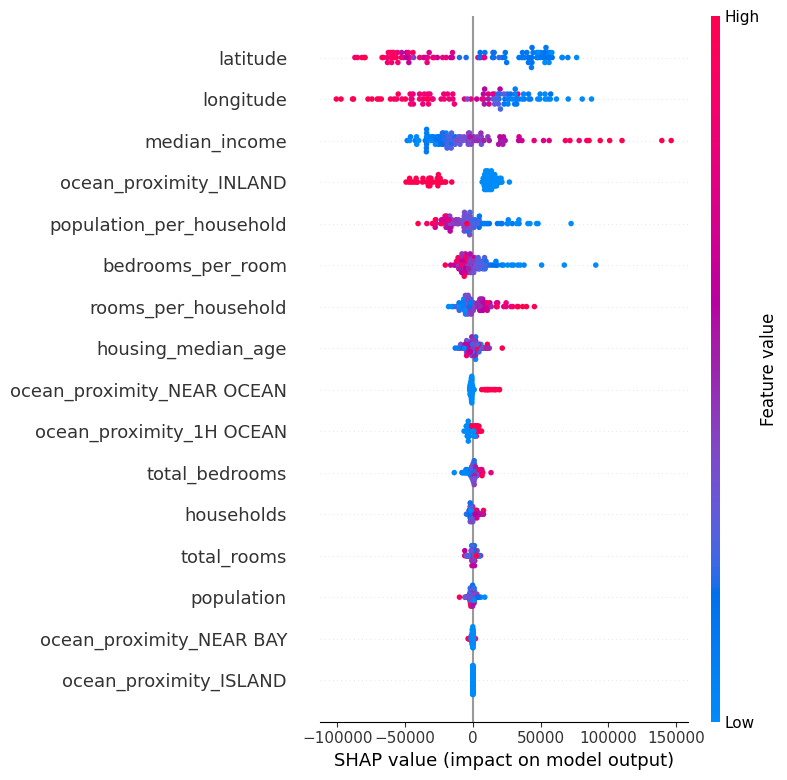

In [0]:
# Set this flag to True and re-run the notebook to see the SHAP plots
shap_enabled = True
if shap_enabled:
    mlflow.autolog(disable=True)
    mlflow.sklearn.autolog(disable=True)
    from shap import KernelExplainer, summary_plot
    # SHAP cannot explain models using data with nulls.
    # To enable SHAP to succeed, both the background data and examples to explain are imputed with the mode (most frequent values).
    mode = X_train.mode().iloc[0]

    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, X_train.shape[0]), random_state=61339316).fillna(mode)

    # Sample some rows from the validation set to explain. Increase the sample size for more thorough results.
    example = X_val.sample(n=min(100, X_val.shape[0]), random_state=61339316).fillna(mode)

    # Use Kernel SHAP to explain feature importance on the sampled rows from the validation set.
    predict = lambda x: best_model.predict(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="identity")
    shap_values = explainer.shap_values(example, l1_reg=False, nsamples=500)
    summary_plot(shap_values, example)
